# Reproductie van oorspronkelijke

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import wave
import operator
import itertools
import os

In [6]:
def plotSoundChunksWithParams(alpha, thresholdFactor, minimalSoundTime, filename, NFFT=None):

    silenceStart = 1
    silenceEnd = 5
    soundThreshold = getSoundThresholdFromFile(filename, silenceStart, silenceEnd, alpha, thresholdFactor)
    print('Threshold: {}'.format(soundThreshold))
    start = 181.25
    end = start + 1

    chunks = {}
    timeChunks = []
    wavFile = wave.open(filename, 'rb')
    wavFile.rewind()
    nFrames = wavFile.getnframes()
    framerate = wavFile.getframerate()
    frames = wavFile.readframes(int(end * framerate))[int(start * 2 * framerate):int(end * 2 * framerate)]
    signal = np.fromstring(frames, np.int16)  # 2* framerate, because conversion int16
    wavFile.close()

    soundChunks = getSoundChunkIndices(signal, alpha, soundThreshold)
    nr = 1

    for chunk in soundChunks:
        startTime = chunk[0] * 1.0 / framerate + start
        endTime = chunk[1] * 1.0 / framerate + start

        if endTime - startTime > minimalSoundTime:
            timeChunks.append([startTime, endTime])

    # plot figure
    fig = plt.figure()
    xs = np.array(range(len(signal))) * 1.0 / framerate + start
    plt.plot(xs, signal, '#36d81c', label='base signal')
    plt.plot(xs, lowpass(signal, alpha), 'b',linewidth='1', label='lowpass signal')
    plt.plot(xs, [soundThreshold] * len(signal), 'r', label='threshold')
    plt.plot(xs,[0] * len(signal), 'k', linewidth='1')

    # plot boundaries of chunks
    for chunk in timeChunks:
        maxVal = max(abs(signal))

        offset = 15
        xRectLow = chunk[0]
        rectWidth = chunk[1] - chunk[0]
        yRectLow = -maxVal - offset
        rectHeight = 2 * (maxVal + offset)
        plt.gca().add_patch(plt.Rectangle((xRectLow, yRectLow), rectWidth, rectHeight, fc='0.9'))

        plt.plot([chunk[0], chunk[0]], [-maxVal, maxVal], '0.4')
        plt.plot([chunk[1], chunk[1]], [-maxVal, maxVal], '0.4')
    plt.title('alpha: {:}, threshold factor: {:}'.format(alpha, thresholdFactor))
    plt.legend(loc='lower left')
#     plt.axis('off')
    plt.show()
    print('timechunks: ')
    print(timeChunks)


In [7]:
def lowpass(signal, alpha):
    lowpassSig = [0] * len(signal)
    lowpassSig[0] = abs(signal[0])
    abssigTimesAlpha = alpha * np.array(abs(signal))

    for i in range(1, len(abssigTimesAlpha)):
        lowpassSig[i] = (abssigTimesAlpha[i] + (1 - alpha) * lowpassSig[i - 1])
    return lowpassSig


def getSoundThresholdFromFile(filename, start, end, alpha, thresholdfactor):
    wavFile = wave.open(filename, 'rb')
    framerate = wavFile.getframerate()
    startIndex = int(2 * start * framerate)
    endIndex = int(2 * end * framerate)
    signal = np.fromstring(wavFile.readframes(endIndex)[startIndex: endIndex], np.int16)
    wavFile.close()
    return getSoundThresholdFromSignal(signal, alpha, thresholdfactor)


def getSoundThresholdFromSignal(signal, alpha, thresholdFactor):
    lpsig = lowpass(signal, alpha)
    return thresholdFactor * np.max(lpsig)

In [8]:
def getSoundChunkIndices(signal, alpha, threshold):
    lpSig = lowpass(signal, alpha)
    indices = np.array(range(len(signal)))
    indices = indices[lpSig > threshold]

    soundIndexList = []
    for k, g in itertools.groupby(enumerate(indices), lambda i_x: i_x[0] - i_x[1]):
        soundIndexList.append(list(map(operator.itemgetter(1), g)))

    chunkIndices = []

    for chunk in soundIndexList:
        if len(chunk) > 1:
            chunkIndices.append([chunk[0], chunk[-1]])

    return chunkIndices

C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()
C:\Users\Etto\Anaconda2\envs\py36DL\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Threshold: 68.35695469652087


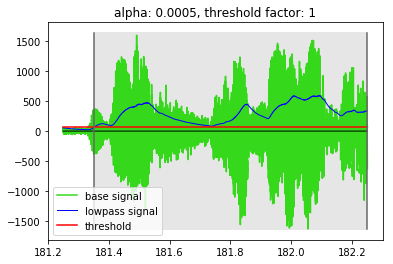

timechunks: 
[[181.3530612244898, 182.24997732426303]]
Threshold: 102.53543204478132


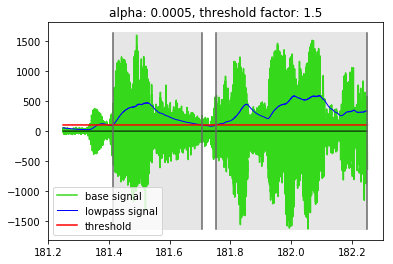

timechunks: 
[[181.41333333333333, 181.70573696145124], [181.7525850340136, 182.24997732426303]]
Threshold: 137.06607294204318


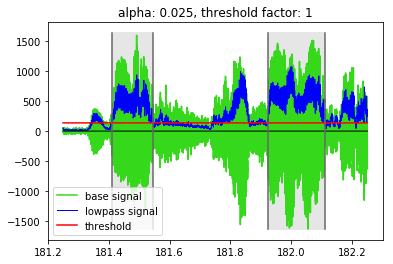

timechunks: 
[[181.4107029478458, 181.54408163265308], [181.92396825396824, 182.11088435374148]]
Threshold: 205.59910941306475


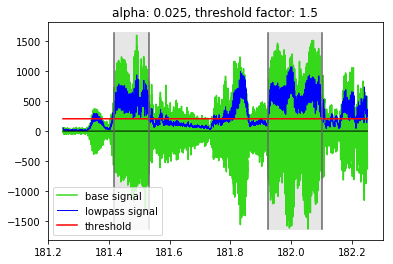

timechunks: 
[[181.417641723356, 181.53167800453514], [181.9242403628118, 182.09945578231293]]


In [9]:
datasetDir = '../E_SAA_DATA/localizationRecordings/20160919'
filename = datasetDir + '/160919_218_mono1.wav'
minimalSoundTime = 0.1  # seconds
for alpha in [0.0005, 0.025]: #[0.00005, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05]:
    for thresholdFactor in [1, 1.5]:
        plotSoundChunksWithParams(alpha, thresholdFactor, minimalSoundTime, filename)